# 화자 분리(Speaker Diarization)

* Speaker Diarization(화자 분리)는 오디오에서 각 부분에서의 화자를 인식하는 기술


## UIS-RNN

* 대표적인 모델 Unbounded Interleaved-State Recurrent Neural Network (UIS-RNN)

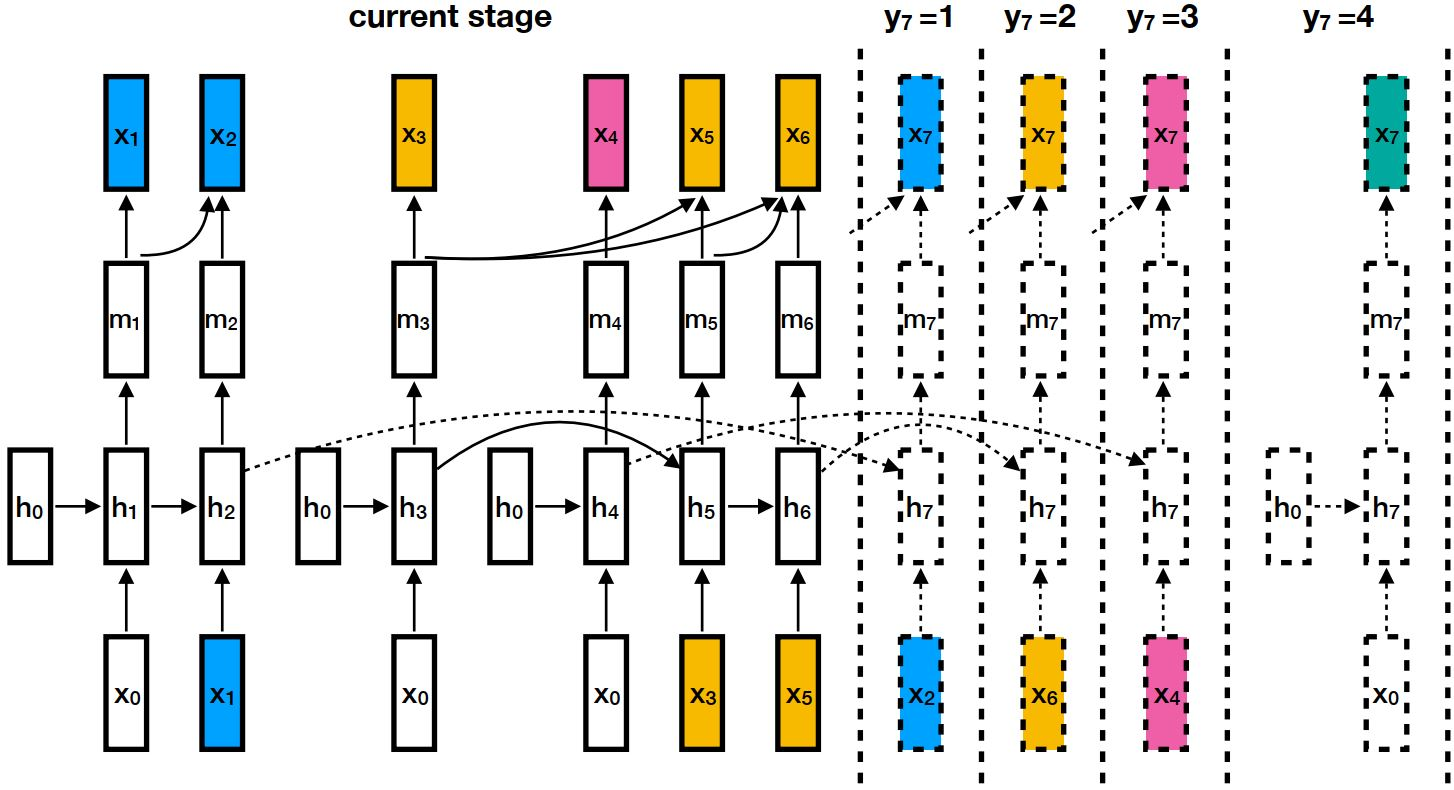

## 라이브러리 설치


*   uisrnn을 간편하게 구현할 수 있는 uisrnn 라이브러리가 존재
*   여기서는 uisrnn 라이브러리를 통해 uisrnn을 구현하고 학습, 평가
*   실습을 위해 uisrnn과 easydict 라이브러리를 설치




In [1]:
!pip install uisrnn easydict

## 데이터 다운로드

* 학습 및 평가에는 uisrnn 라이브러리에서 제공하는 sample dataset을 사용
* urlretrieve를 통해 url에서 데이터를 받아옴
* https://github.com/google/uis-rnn/blob/master/data/toy_training_data.npz?raw=True
* https://github.com/google/uis-rnn/blob/master/data/toy_testing_data.npz?raw=True



In [2]:
import urllib.request

training_url = 'https://github.com/google/uis-rnn/blob/master/data/toy_training_data.npz?raw=True'
urllib.request.urlretrieve(training_url, './toy_training_data.npz')

testing_url = 'https://github.com/google/uis-rnn/blob/master/data/toy_testing_data.npz?raw=True'
urllib.request.urlretrieve(testing_url, './toy_testing_data.npz')

('./toy_testing_data.npz', <http.client.HTTPMessage at 0x7fb844459f50>)



*   다운로드한 데이터에서 데이터를 받아오고 sequence와 label을 분리



In [3]:
import numpy as np
import uisrnn

train_data = np.load('./toy_training_data.npz', allow_pickle=True)
test_data = np.load('./toy_testing_data.npz', allow_pickle=True)

train_sequence = train_data['train_sequence']
train_cluster_id = train_data['train_cluster_id']

test_sequences = test_data['test_sequences'].tolist()
test_cluster_ids = test_data['test_cluster_ids'].tolist()

## 파라미터 설정

*   model, training, inference에 필요한 인자들은 uisrnn.parse_argement()를 통해 얻을 수 있음
*   colab 환경에서는 argument를 사용할 수 없기 때문에 easydict로 대체



In [4]:
import easydict

model_args = easydict.EasyDict({"crp_alpha" : 1.0,
                                "enable_cuda": True,
                                "observation_dim": 256,
                                "rnn_depth": 1,
                                "rnn_dropout": 0.2,
                                "rnn_hidden_size": 512,
                                "sigma2": None,
                                "transition_bias": None,
                                "verbosity": 2})

training_args = easydict.EasyDict({"batch_size": 10,
                                   "enforce_cluster_id_uniqueness": True,
                                   "grad_max_norm": 5.0,
                                   "learning_rate": 0.001,
                                   "num_permutations": 10,
                                   "optimizer": 'adam',
                                   "regularization_weight": 1e-05,
                                   "sigma_alpha": 1.0,
                                   "sigma_beta": 1.0,
                                   "train_iteration": 5000})

inference_args = easydict.EasyDict({"batchsize": 100,
                                    "look_ahead": 1,
                                    "test_iteration": 2,
                                    "beam_size": 10})


## UISRNN 모델 학습



*   앞서 구성한 argment를 사용해 모델을 구성
*   데이터를 입력해 모델을 훈련



In [8]:
model = uisrnn.UISRNN(model_args)

model.fit(train_sequence, train_cluster_id, training_args)

Iter: 0  	Training Loss: -283.5125    
    Negative Log Likelihood: 6.2499	Sigma2 Prior: -289.7630	Regularization: 0.0006
Iter: 10  	Training Loss: -298.0432    
    Negative Log Likelihood: 5.6894	Sigma2 Prior: -303.7332	Regularization: 0.0006
Iter: 20  	Training Loss: -310.9951    
    Negative Log Likelihood: 6.2838	Sigma2 Prior: -317.2796	Regularization: 0.0006
Iter: 30  	Training Loss: -326.8634    
    Negative Log Likelihood: 7.2155	Sigma2 Prior: -334.0795	Regularization: 0.0006
Iter: 40  	Training Loss: -344.9842    
    Negative Log Likelihood: 8.2732	Sigma2 Prior: -353.2581	Regularization: 0.0006
Iter: 50  	Training Loss: -370.8084    
    Negative Log Likelihood: 10.3554	Sigma2 Prior: -381.1645	Regularization: 0.0007
Iter: 60  	Training Loss: -397.2172    
    Negative Log Likelihood: 13.8024	Sigma2 Prior: -411.0203	Regularization: 0.0007
Iter: 70  	Training Loss: -439.8622    
    Negative Log Likelihood: 22.5394	Sigma2 Prior: -462.4023	Regularization: 0.0007
Iter: 80  	Tra

## 모델 평가



*   평가 데이터를 사용해 각 sequence에 해당하는 화자 id를 얻음



In [10]:
predicted_cluster_ids = []
test_record = []

for (test_sequence, test_cluster_id) in zip(test_sequences, test_cluster_ids):
    predicted_cluster_id = model.predict(test_sequence, inference_args)
    predicted_cluster_ids.append(predicted_cluster_id)
    accuracy = uisrnn.compute_sequence_match_accuracy(test_cluster_id, predicted_cluster_id)
    test_record.append((accuracy, len(test_cluster_id)))
    print('Ground truth labels:')
    print(test_cluster_id)
    print('Predicted labes:')
    print(predicted_cluster_id)
    print('-' * 100)

output_result = uisrnn.output_result(model_args, training_args, test_record)
print(output_result)

Ground truth labels:
['15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_0', '15_0', '15_0', '15_0', '15_0', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1']
Predicted labes:
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,